# Financial Sentiment Analysis Using Classical and Transformer-Based Models
This notebook demonstrates an end-to-end sentiment analysis pipeline using machine learning and transformer models on a labeled financial news dataset from Kaggle.

In [2]:
!pip install pandas scikit-learn matplotlib seaborn transformers torch
!pip install accelerate
!pip install --upgrade transformers

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, Trainer, TrainingArguments
from transformers import pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import torch
from sklearn.utils.class_weight import compute_class_weight

In [3]:
df = pd.read_csv('C:/Users/Asus/Downloads/archive/all-data.csv', names=["Sentiment", "News Headline"], encoding='ISO-8859-1')
print(df.head())
print(df['Sentiment'].value_counts())

  Sentiment                                      News Headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
Sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [4]:
# Preprocess the text

def financial_preprocess(text):
   
    text = str(text).lower()


    text = re.sub(r'\$(\d+[\d.,]*)', r'dollar\1', text)  # $7M → dollar7M
    text = re.sub(r'(\d+[\d.,]*)%', r'\1percent', text)  # 5% → 5percent
    text = re.sub(r'usd(\d+)', r'dollar\1', text)
    text = re.sub(r'eur(\d+)', r'euro\1', text)

    # Expand the financial terms found in our dataset
    financial_terms = {
        r'\bq1\b': 'quarter_one',
        r'\bq2\b': 'quarter_two',
        r'\bq3\b': 'quarter_three',
        r'\bebitda\b': 'earnings_before_interest_tax_depreciation_amortization',
        r'\broi\b': 'return_on_investment',
    }
    for pattern, replacement in financial_terms.items():
        text = re.sub(pattern, replacement, text)

    # Remove URLs if any
    # text = re.sub(r"http\S+|www\S+", "", text)

    # Clean everything except letters, numbers, $, %
    text = re.sub(r"[^a-z0-9\$\% ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text


# View random cleaned rows
df['cleaned'] = df['News Headline'].apply(financial_preprocess)
df[['News Headline', 'cleaned']].sample(10)

,News Headline,cleaned
3756,Teleste expects to start the deliveries at the...,teleste expects to start the deliveries at the...
4738,"In January-November 2009 , the group 's sales ...",in january november 2009 the group s sales tot...
2600,The company 's board of directors will propose...,the company s board of directors will propose ...
1734,The stock is trading above both its MAPs and t...,the stock is trading above both its maps and t...
2982,It rose by 15.7 % and by 24.8 % in Finland and...,it rose by 15 7 % and by 24 8 % in finland and...
826,BasWare 's CEO Ilkka Sihvo comments in conjunc...,basware s ceo ilkka sihvo comments in conjunct...
3630,"In banking , Sampo A was unchanged at 14.24 eu...",in banking sampo a was unchanged at 14 24 eur ...
1194,Certain shareholders have irrevocably agreed t...,certain shareholders have irrevocably agreed t...
1942,Marimekko makes all sorts of colorful little i...,marimekko makes all sorts of colorful little i...
3217,The contract has been allotted as per lowest p...,the contract has been allotted as per lowest p...


In [7]:
# Encode labels and split data (using custom labels)
# Set display width and max column width
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', 0)
label_map = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

# Applying the mapping
df['label'] = df['Sentiment'].map(label_map)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned'], df['label'], test_size=0.3, random_state=42)

print(df[['News Headline', 'Sentiment', 'label']].sample(10))

                                          News Headline Sentiment  label
3542  BAVARIA Industriekapital AG 's 2006 revenues w...   neutral      1
1000  Incap Corporation Stock Exchange Release 4 May...   neutral      1
556   STX Finland Oy signed a a preliminary agreemen...  positive      2
859   Last year SysOpen Digia invested in IBM produc...  positive      2
4685  ( ADP News ) - Feb 12 , 2009 - Finnish constru...  negative      0
2929  He is a Chartered Accountant in British Columb...   neutral      1
2589  The buildings , with about 40 condominiums eac...   neutral      1
174   Both operating profit and turnover for the six...  positive      2
4149  A total of 1,800,000 stock options were issued...   neutral      1
1745  A memorandum of understanding on cooperation b...  positive      2


In [5]:
# TF-IDF Vectorization

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [8]:
# # Sentiment Classification Using Logistic Regression

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [300, 1000]
}

grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid_lr, cv=5, scoring='f1_macro', verbose=1)
grid_lr.fit(X_train_vec, y_train)

# Use best estimator
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_vec)

# Evaluation
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='macro', zero_division=0)

print("Logistic Regression Results:")
print("Best Params:", grid_lr.best_params_)
print(f"Accuracy: {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall: {rec_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Logistic Regression Results:
Best Params: {'C': 10, 'max_iter': 300, 'solver': 'lbfgs'}
Accuracy: 0.7600
Precision: 0.7247
Recall: 0.7170
F1-score: 0.7207


In [9]:
# # Sentiment Classification Using BERT

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Stratified split
X_train_texts, X_val_texts, y_train_labels, y_val_labels = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

# Tokenize inputs
train_encodings = tokenizer(list(X_train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val_texts), truncation=True, padding=True, max_length=128)

# Dataset class
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            **{key: torch.tensor(val[idx]) for key, val in self.encodings.items()},
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = FinancialDataset(train_encodings, y_train_labels.tolist())
val_dataset = FinancialDataset(val_encodings, y_val_labels.tolist())


classes = np.unique(y_train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Custom Trainer with class weights
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs['labels'].to(device)
        outputs = model(**{k: v.to(device) for k, v in inputs.items()})
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# Train
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.087700
20,1.080900
30,1.059700
40,1.015700
50,0.890500
60,0.932400
70,0.881600
80,0.829300
90,0.696600
100,0.579200


TrainOutput(global_step=680, training_loss=0.33931943642742496, metrics={'train_runtime': 4234.8563, 'train_samples_per_second': 2.563, 'train_steps_per_second': 0.161, 'total_flos': 451718460046728.0, 'train_loss': 0.33931943642742496, 'epoch': 4.0})

In [11]:
# Tokenize test set
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    y_pred_bert = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Metrics
acc = accuracy_score(y_test, y_pred_bert)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_bert, average='macro', zero_division=0)

print("Fine-tuned BERT Results (with Class Weights):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Fine-tuned BERT Results (with Class Weights):
Accuracy: 0.8487
Precision: 0.8238
Recall: 0.8462
F1-score: 0.8343


In [12]:
# Sentiment Classification Using FinBERT

# Load FinBERT pipeline
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert",
    device=-1
)


def get_finbert_predictions_batch(texts, batch_size=16):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts.iloc[i:i+batch_size] if hasattr(texts, 'iloc') else texts[i:i+batch_size]
        batch = [str(t)[:512] for t in batch]
        try:
            results = finbert_pipeline(batch)
            for res in results:
                label = res['label'].lower()
                if 'positive' in label:
                    predictions.append(2) 
                elif 'negative' in label:
                    predictions.append(0)
                else:
                    predictions.append(1)
        except Exception as e:
            print(f"Batch {i//batch_size} failed: {e}")
            predictions.extend([1] * len(batch))  # fallback to neutral
    return np.array(predictions)

# Apply FinBERT to test set
y_pred_finbert = get_finbert_predictions_batch(X_test)

# Evaluate FinBERT predictions
acc_bert = accuracy_score(y_test, y_pred_finbert)
prec_bert, rec_bert, f1_bert, _ = precision_recall_fscore_support(
    y_test, y_pred_finbert, average='macro', zero_division=0
)

print("FinBERT Results:")
print(f"Accuracy: {acc_bert:.4f}")
print(f"Precision: {prec_bert:.4f}")
print(f"Recall: {rec_bert:.4f}")
print(f"F1-score: {f1_bert:.4f}")

Device set to use cpu


FinBERT Results:
Accuracy: 0.8989
Precision: 0.8744
Recall: 0.9127
F1-score: 0.8916


In [13]:
# # Sentiment Classification Using SVM

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid search
grid_svm = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, cv=5, scoring='f1_macro', verbose=1)
grid_svm.fit(X_train_vec, y_train)

# Use best estimator
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_vec)

# Evaluation
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm, rec_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='macro', zero_division=0)

print("SVM Results:")
print("Best Params:", grid_svm.best_params_)
print(f"Accuracy: {acc_svm:.4f}")
print(f"Precision: {prec_svm:.4f}")
print(f"Recall: {rec_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVM Results:
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7586
Precision: 0.7100
Recall: 0.7249
F1-score: 0.7166


In [14]:
# # Sentiment Classification Using Random Forest

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Grid search
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_vec, y_train)

# Use best estimator
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_vec)

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='macro', zero_division=0)

print("Tuned Random Forest Results:")
print("Best Params:", grid_rf.best_params_)
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuned Random Forest Results:
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7428
Precision: 0.7193
Recall: 0.6473
F1-score: 0.6695


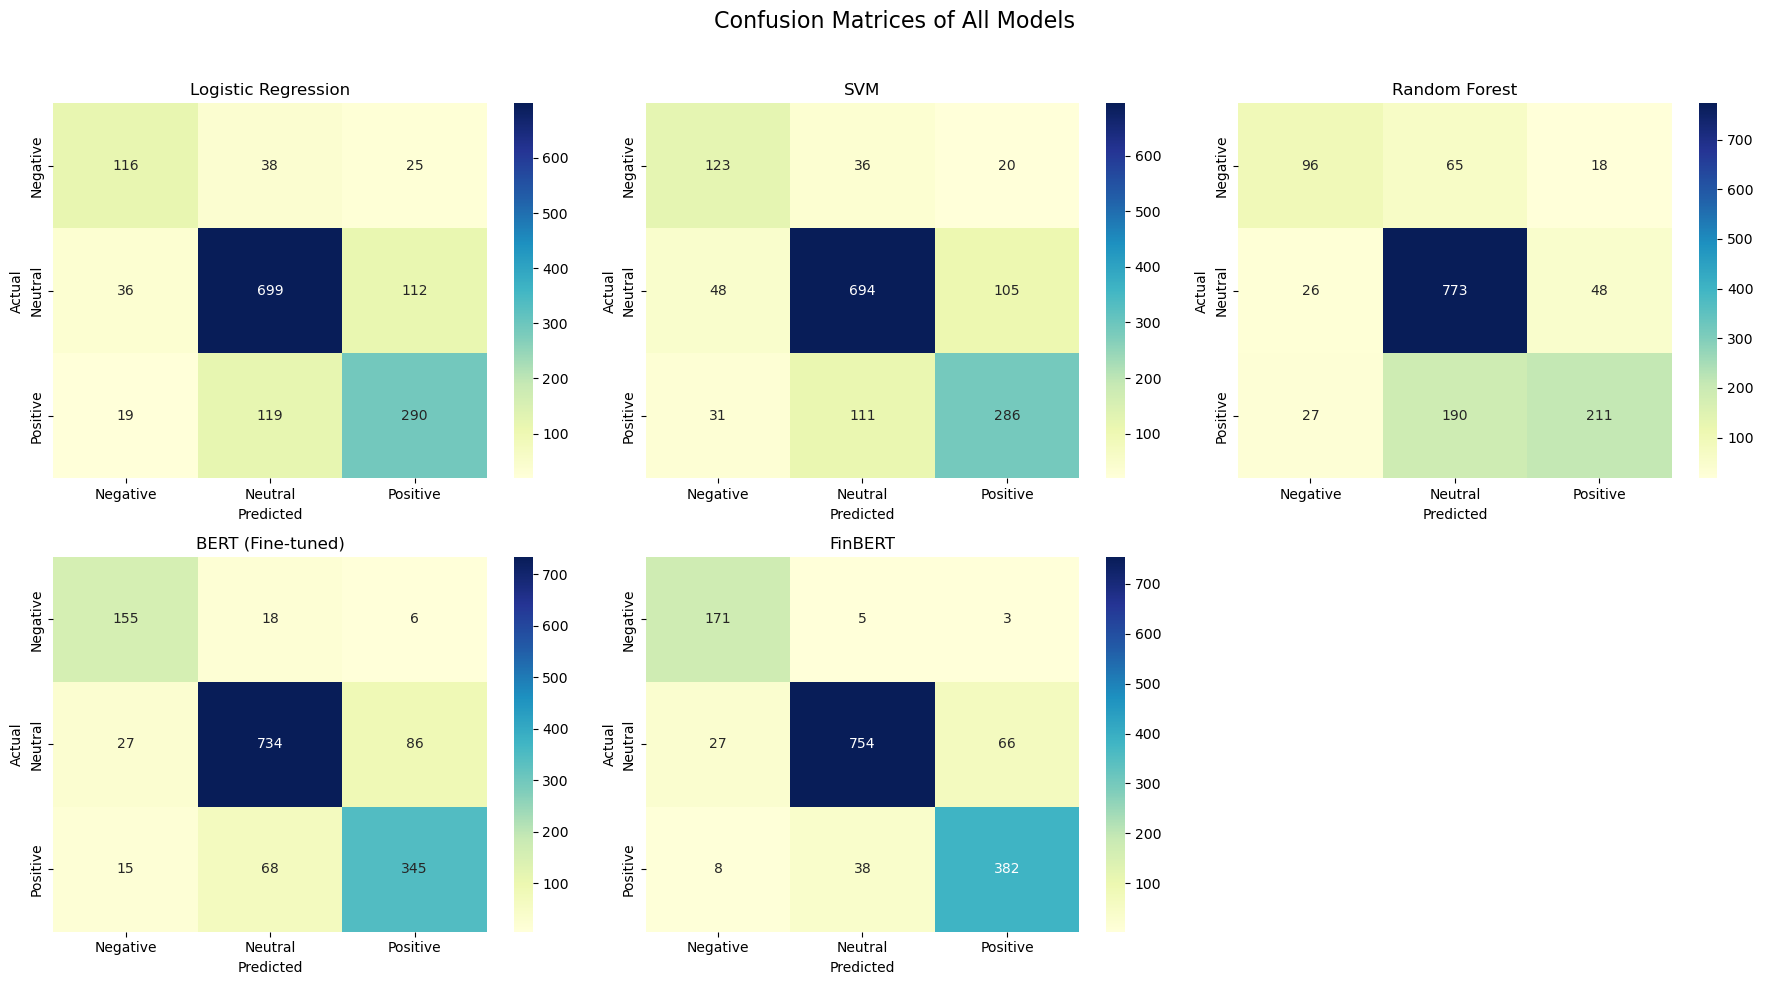

In [15]:
# # Confusion Matrices of All Models

label_ids = [0, 1, 2]
labels = ['Negative', 'Neutral', 'Positive']

# Confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=label_ids)
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=label_ids)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=label_ids)
cm_bert = confusion_matrix(y_test, y_pred_bert, labels=label_ids)
cm_finbert = confusion_matrix(y_test, y_pred_finbert, labels=label_ids)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices of All Models', fontsize=16)

conf_matrices = [
    (cm_lr, "Logistic Regression", axes[0, 0]),
    (cm_svm, "SVM", axes[0, 1]),
    (cm_rf, "Random Forest", axes[0, 2]),
    (cm_bert, "BERT (Fine-tuned)", axes[1, 0]),
    (cm_finbert, "FinBERT", axes[1, 1]),
]

for cm, title, ax in conf_matrices:
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Hide unused subplot
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
# All Models Comparison Table

comparison_table = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Accuracy': acc_lr, 'Precision': prec_lr, 'Recall': rec_lr, 'F1-score': f1_lr},
    {'Model': 'SVM', 'Accuracy': acc_svm, 'Precision': prec_svm, 'Recall': rec_svm, 'F1-score': f1_svm},
    {'Model': 'Random Forest', 'Accuracy': acc_rf, 'Precision': prec_rf, 'Recall': rec_rf, 'F1-score': f1_rf},
    {'Model': 'BERT (Fine-tuned)', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1},
    {'Model': 'BERT (FinBERT)', 'Accuracy': acc_bert, 'Precision': prec_bert, 'Recall': rec_bert, 'F1-score': f1_bert}
])

display(comparison_table.round(4))

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.7600,0.7247,0.7170,0.7207
1,SVM,0.7586,0.7100,0.7249,0.7166
2,Random Forest,0.7428,0.7193,0.6473,0.6695
3,BERT (Fine-tuned),0.8487,0.8238,0.8462,0.8343
4,BERT (FinBERT),0.8989,0.8744,0.9127,0.8916


**Logistic Regression**: Achieves solid overall performance with accuracy of 76.0% and F1-score of 0.7207. It correctly classifies 699 neutral and 290 positive samples. While it handles neutral and positive classes reasonably well, it shows confusion between positive and neutral, and slightly lower sensitivity to negative samples.

**SVM**: Performs comparably to Logistic Regression with accuracy of 75.9% and F1-score of 0.7166. It predicts 694 neutral and 286 positive samples correctly. However, it exhibits more confusion between neutral and the other two classes, particularly misclassifying a fair number of positive and negative examples as neutral.

**Random Forest**: Scores 73.3% accuracy and F1-score of 0.6601. It performs best on the neutral class (758 correct), but shows more confusion between neutral and positive, with 181 positives misclassified as neutral — indicating a tendency to overpredict the dominant class.

**Bert(Fine-tuned)**: Clearly outperforms traditional models with 84.9% accuracy and F1-score of 0.8303. It correctly predicts 748 neutral and 334 positive examples. Misclassification rates are low, especially for the neutral class, with balanced performance across all classes. It also improves detection of negative samples (152 correct), reducing prior confusion.

**FinBERT**: Delivers the best overall performance, achieving 89.9% accuracy and F1-score of 0.8916. It correctly predicts 171 negative, 754 neutral, and 382 positive samples. Misclassifications are minimal, and the model shows exceptional balance across all sentiment classes — making it the most robust and accurate choice for financial sentiment analysis in this task.

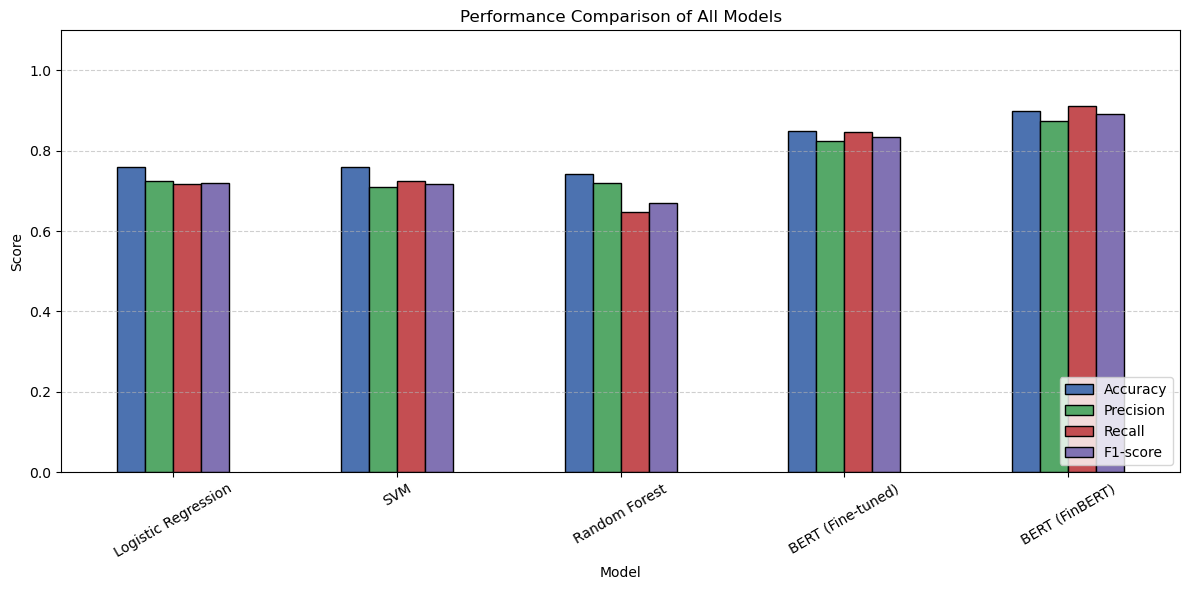

In [17]:
# Visual charts of All Models

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

comparison_table.set_index('Model')[metrics].plot(
    kind='bar',
    figsize=(12, 6),
    color=colors,
    edgecolor='black'
)

plt.title('Performance Comparison of All Models')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=30)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Conclusion**

In this project, we evaluated multiple models for sentiment classification of financial news headlines using the Kaggle financial news dataset. We compared traditional machine learning models (Logistic Regression, SVM, Random Forest) with transformer-based models (BERT and FinBERT).

While the classical models performed reasonably well, particularly on the neutral sentiment class, they struggled to effectively distinguish positive sentiment from negative or neutral. This highlighted the limitations of classical models in understanding the nuanced context of financial news.

On the other hand, transformer-based models exhibited a clear advantage. BERT, which was fine-tuned on the entire dataset (all-data.csv), achieved remarkable results, outperforming all classical models. It showed significant improvements in classifying positive and negative sentiments, and its performance was almost on par with FinBERT—a model pre-trained on a large corpus of financial text. Specifically, BERT (Fine-tuned) achieved an F1-score of 0.83 and an accuracy of 84%, which is close to FinBERT's 89.9% accuracy, showcasing its ability to learn context-specific financial language even without domain-specific pretraining.

The results emphasize that fine-tuning BERT on domain-specific data can yield strong performance, and in some cases, it can almost match the performance of models like FinBERT that are pre-trained on financial text. This makes BERT (Fine-tuned) a highly reliable and effective model for real-world financial sentiment analysis.